
Investigating Detectors
=====

**Version 0.1**

Understanding the behavior of the CCDs in a camera requires digging deep into calibration exposures. That is where you can uncover effects that might not be noticible in on-sky exposures, but may subtly contaminate the data if left uncorrected. It is also how camera engineering teams optimize and debug the performance of the camera when it's still in the lab. 

We're going to look at two test exposures taken with one of the Rubin Observatory CCDs. They're both biases; each image has a zero second exposure time and the detector was not illuminated.

Please download a tarball of the images for this notebook: [investigating_detectors.tar.gz](https://northwestern.box.com/s/nfa3owg2wpyknca415gl017ny6phx6w6). As a reminder, you can unpack these files via `tar -zxvf investigating_detectors.tar.gz`

* * *

By C Slater (University of Washington)

In [5]:
from astropy.io import fits

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.dpi'] = 120

Photon Transfer Curve
====

1) Simulated Images
-----

The "Photon Transfer Curve" is the name given to the relationship between the signal level and the noise level in a sensor. We're going to do a few experiments to show how it works in principle, and then we'll look at some real images and make some diagnostic measurements.


First we need a model of the noise in CCD image. I'm going to give this to you so we all start out on the same page

In [89]:
def simulated_image(signal_level, read_noise, gain):
    """
    Return a 1-D simulated "image" with the noise properties of
    a CCD sensor. The image is always 1000 pixels long.
    
    signal_level is the mean number of electrons in each pixel.
    read_noise is the noise of the readout amplifier, in electrons.
    gain is the number of electrons per ADU.
    
    """
    return (1/gain) * (read_noise*np.random.randn(1000) +  np.random.poisson(signal_level, size=1000))

Before diving in to programming, take a careful look at the components in the simulated image. What are the two noise sources, and why do they have that functional form? We're going to be looking a lot at the image "gain"; does it make sense how that is applied?

Let's make some simulations. What we want to do is loop over a set of input levels light levels, from zero to "full well" capacity (on order of 10,000 electrons). For each simulated image, we want to measure the mean signal level (because that's what we see as users of a CCD) and the standard deviation of that image. Save those in two lists, but at the end convert those back to numpy arrays to make downstream usage easier.

For right now, set the read noise to 5, and the gain to 0.8.

In [149]:
# Answer
noise_levels = []
measured_signal_levels = []
input_signal_levels = np.logspace(0, 4, 30)

for input_signal_level in input_signal_levels:
    image = simulated_image(input_signal_level, 5, 0.8)
    noise_levels.append(np.std(image))
    measured_signal_levels.append(np.mean(image))

noise_levels = np.array(noise_levels)
measured_signal_levels = np.array(measured_signal_levels)

Plot the noise vs. the measured signal level, on a log-log plot.

What is the behavior you see? What are the two different noise regimes?

Fit a straight line to the "bright" portion of the data (high signal levels) and print the resulting coefficients. Remember that you're looking at a log-log plot, and so you want to fit the logs of the variables. You can add this to the plot in the cell above.

Why does the line have that value of the slope?

[0.48765492 0.10125341]


Text(0.5, 0, 'Measured Signal Level')

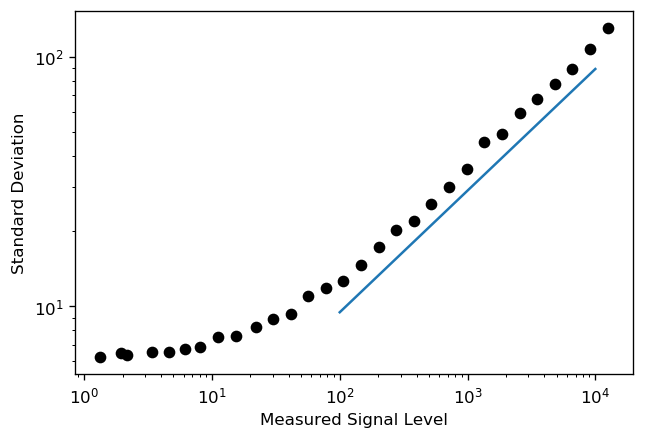

In [153]:
# Answer
high_counts, = np.where(signal_levels > 100)
fit = np.polyfit(np.log10(measured_signal_levels[high_counts]), np.log10(noise_levels[high_counts]), 1)
print(fit)
x = np.logspace(2, 4, 10)
plt.loglog(measured_signal_levels, noise_levels, 'ko')
plt.plot(x, 10**(fit[0]*np.log10(x) ), '-')
plt.ylabel("Standard Deviation")
plt.xlabel("Measured Signal Level")

Now we're going to plot something slightly different. Plot the *variance* this time, and on a linear plot instead of log-log (again vs. measured signal level). Fit a straight line to the data (in linear space) and print the coefficients. Also print the *reciprocal* of the slope.

Where did this slope come from? 

[0.76749132 0.06128096]


Text(0.5, 0, 'Measured Signal Level')

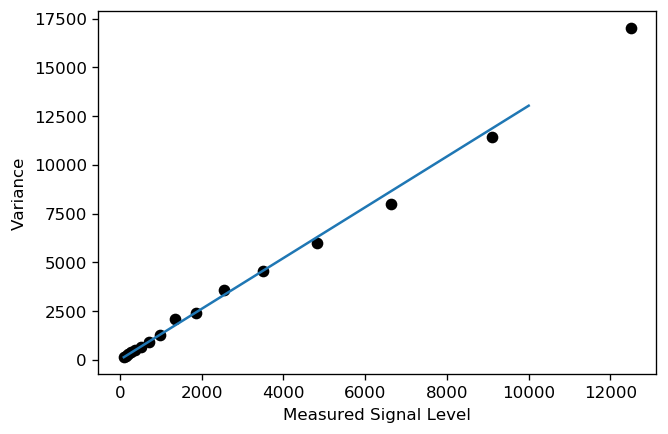

In [159]:
# Answer
high_counts, = np.where(measured_signal_levels > 100)

plt.plot(measured_signal_levels[high_counts], (noise_levels[high_counts])**2, 'ko')
fit = np.polyfit(measured_signal_levels, noise_levels**2, 1)
print(1/fit)

plt.plot(x, fit[0] * x, '-')
plt.ylabel("Variance")
plt.xlabel("Measured Signal Level")

The slope here is related to the gain (either proportionally or inversely, depending on how one chooses to define gain). This can be summarized as

$$ \frac{1}{\textrm{gain}} =  \langle \frac{\textrm{Variance}}{\textrm{Mean Signal Level}} \rangle $$

It's a clever and useful trick, or at least it seems like a trick, because the standard deviation plot wasn't affected by the gain at all. Go back and try varying the gain and re-run the plots, and you'll see what does and doesn't change.

One way to think of it is that the measured signal level is affected linearly by the gain, but the variance is affected by the square of the gain. Dividing these two gives you a linear relation back, but when dividing the square root of the variance, the gain cancels out.


2) Looking at real bias frames
------

Remember that a bias frame is an image that is exposed for zero seconds; it's just immediately read-out without being exposed to light. You might think that is a pretty boring image, particularly if you're at the telescope and getting ready for a night of observing. But to a camera engineer, bias frames hold lots of information about how the camera is operating.

We're going to look at images from one example LSST sensor; this was taken on a test stand and not the actual camera, so don't take it as representative of real camera performance.

Our first step is, as usual, to look at the image and make sure it seems reasonable.

In [166]:
bias1_file = fits.open("00258334360-S10-det003.fits")
bias1_data = bias1_file[1].data

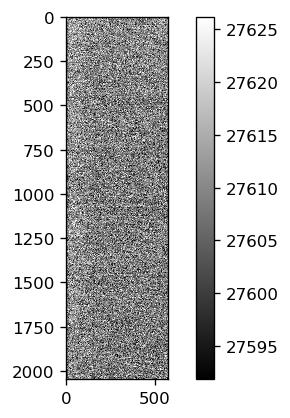

In [168]:
plt.imshow(bias1_data, cmap='gray', 
           vmin=(np.median(data) - 0.2*np.std(data)), 
           vmax=(np.median(data) + 0.2*np.std(data)))
plt.colorbar()

Notice that when we plotted `bias1_file[1].data`, the image we get is 2048 by 576 pixels. Because LSST sensors have 16 separate amplifiers, the data from each one of them is put in a different "header data unit" (HDU) in the FITS file. You can get to them by substituting n in `bias1_file[n]`, where n is the amplifier number.

3) Looking for structure
------

The bias looks mostly like Gaussian noise, but if you look carefully some parts of the image look like they have some "structure". 

Let's make a few plots: try plotting the mean of the data *along columns* in one plot, and along *rows* in another.

Start with just a single amplifier, but if you like you can learn more by plotting each amplifier as a different line. Hint: the amplifiers each have different mean levels that you probably want to subtract off.

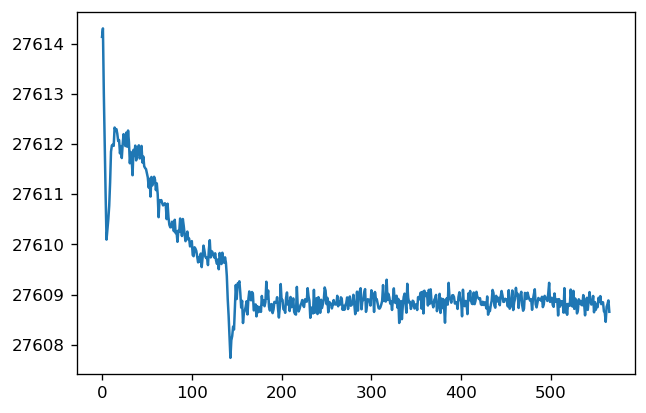

In [170]:
columns_summed = np.mean(bias1_data, axis=0)
plt.plot(columns_summed[10:])

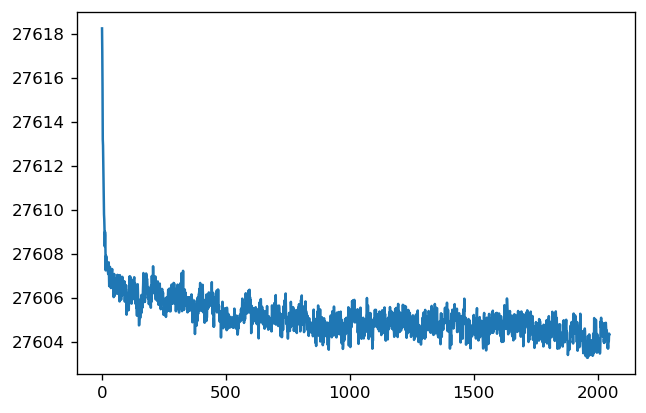

In [171]:
rows_summed = np.mean(bias1_data, axis=1)
plt.plot(rows_summed)

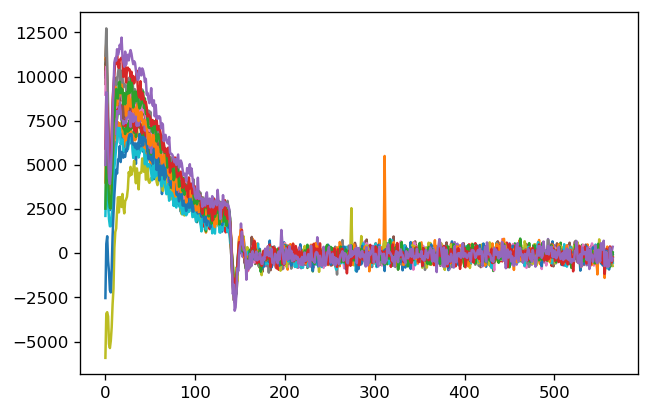

In [37]:
for hdu in range(1, 16):
    hdu_data = bias1_file[hdu].data
    columns_summed = np.sum(hdu_data, axis=0)
    plt.plot(columns_summed[10:] - np.median(columns_summed))

These "simple" bias frames turn out to have a lot of structure in them, particularly at the start of columns. This isn't something we can dive much further into, because it's really an electronics problem (that was known about at the time). It's also worth noting that it's fractionally a small effect. We will have to make sure our subsequent analyses are not affected by the issue though.

4) Measuring the noise
------

Bias images usually have some repeatable structure to them, so a useful trick is to use the *difference* of two bias frames taken close in time. Let's measure the standard deviation for the differences between the biases, doing so separately for each amplifier. This isn't the final read noise value yet, because it's still in ADU and not in electrons. We will store the results in a dictionary for later use. 

We load the second image:

In [62]:
bias2_file = fits.open("00258334672-S10-det003.fits")

In [177]:
# Answer
measured_stddevs = {}

for hdu in range(1, 16):
    hdu_difference = bias1_file[hdu].data - bias2_file[hdu].data
    
    stddev = np.std(hdu_difference)

    measured_stddevs[hdu] = stddev
measured_stddevs

{1: 9.457980927685048,
 2: 9.469125615340754,
 3: 9.359179694346206,
 4: 9.410864043028887,
 5: 12.24121923224962,
 6: 9.859962609804752,
 7: 9.662708085531628,
 8: 9.84712838890329,
 9: 11.039278352448566,
 10: 10.773839466681745,
 11: 9.711413180620667,
 12: 10.442833212917893,
 13: 9.89699060912195,
 14: 10.9139614470604,
 15: 10.382393518498514}

5) Measuring the gain
---

We have just one more step before we can report the read noise. We need to measure the gains so we can convert the noise in ADU into electrons. To do that, we're going to use the trick we saw at the start of this notebook. We need to add two things though: we want to use pairs of images, to cancel out any fixed spatial patterns, and we need images with significant counts in them so that we're not just measuring read noise. The formula we want to implement is thus:

$$ \frac{1}{\textrm{gain}} =  \langle \frac{(I_1 - I_2)^2}{I_1 + I_2} \rangle $$

where $I_1$ and $I_2$ are the pixel values from each image, and the $\langle$ $\rangle$ brackets denote taking the mean of this ratio over all pixels.

We have some flat field images from those same sensors that we can use:

In [61]:
flat1_file = fits.open("00258342968-S10-det003.fits")
flat2_file = fits.open("00258343136-S10-det003.fits")

Since each amplifier can have a slightly different gain, we want to run this per-HDU and output a table of values. Since we're looping over the HDUs, we can also print the finished read noise values at the same time. Note that those have a factor of $\sqrt{2}$ because we took the difference of two bias frames, so the noise is greater than a single image.

In [186]:
# Answer
for hdu in range(1,16):
    flat1_data = flat1_file[hdu].data
    flat2_data = flat2_file[hdu].data
    
    bias1 = bias1_file[hdu].data
    bias2 = bias2_file[hdu].data
    
    debiased_flat1 = flat1_data - bias1
    debiased_flat2 = flat2_data - bias2
    
    squared_noise = (debiased_flat1 - debiased_flat2 )**2
    summed_intensity = ((debiased_flat1) + (debiased_flat2))
    ok_values = (summed_intensity > 5000)
    reciprocal_gain = np.mean(squared_noise[ok_values]/(summed_intensity[ok_values]) ) 
    
    print(hdu, reciprocal_gain, 1/reciprocal_gain, measured_stddevs[hdu]/reciprocal_gain/np.sqrt(2))

1 1.4131997858021668 0.7076140330946735 4.732382864396608
2 1.400973123373611 0.7137895676342111 4.779308626843004
3 1.3936456957882917 0.7175424880384446 4.748652723009572
4 1.3700462262618374 0.7299023790813933 4.857125003589914
5 1.3909367553546554 0.7189399490309852 6.223035731705756
6 1.3823591562418993 0.7234010029047833 5.043585375158979
7 1.3736483017885668 0.7279883786104087 4.974028943951019
8 1.3805056870350125 0.7243722422815618 5.0437831038297505
9 1.3851238880523853 0.7219570816918726 5.6355598584023685
10 1.4235418794384622 0.7024731863838564 5.351619826816092
11 1.3859259105806345 0.721539291794501 4.954814728908817
12 1.426625605082048 0.7009547539576706 5.1759888181942895
13 1.4046034372343128 0.7119447194070779 4.982352304953302
14 1.4221347224243568 0.7031682612286333 5.426585841086119
15 1.4043536434042716 0.7120713537481312 5.2276439744060745


I got values of about 0.7 for the gain, and read noise values around 5 e-. Did those work out for you? 